<h1>Residential Utility Rate vs Median Income by Zip Code</h1>
Sources: <a href="https://catalog.data.gov/dataset/u-s-electric-utility-companies-and-rates-look-up-by-zipcode-2023#sec-dates">2023 National Renewable Energy Laboratory (NREL)</a> & <a href="https://data.census.gov/table?q=per%20capita%20income&g=010XX00US$8600000">2023 ACS 5 Year Estimates</a>

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import select
import pandas as pd
from scipy import stats
import numpy as np
import scipy.stats as stats
matplotlib.style.use('ggplot')

In [67]:
rate = pd.read_csv('iou_zipcodes_2023.csv')

rate['zip'] = rate['zip'].astype(str) \
    .str.zfill(5) 

# Group by column 'zip'
grouped = rate.groupby('zip')

# Calculate the sum of column 'res_rate' for each group
rate_by_zip = grouped['res_rate'].mean()

rate_by_zip.head()

zip
01002    0.254976
01005    0.254976
01007    0.254976
01009    0.254976
01010    0.254976
Name: res_rate, dtype: float64

In [68]:
income_rw = pd.read_csv('median_income.csv') 
income_rw.head()

,Geographic Area Name,Estimate!!Median income (dollars)
0,ZCTA5 00601,18571
1,ZCTA5 00602,21702
2,ZCTA5 00603,19243
3,ZCTA5 00606,20226
4,ZCTA5 00610,23732


In [69]:
income_rw['zip'] = income_rw['Geographic Area Name'].str[-5:]
income_rw.rename(columns={'Estimate!!Median income (dollars)': 'median_income'}, inplace=True)
income = income_rw.replace('-', '').replace('250,000+', '250000').replace('2,500-', '2500')
income["median_income"] = pd.to_numeric(income["median_income"])

income.head()

,Geographic Area Name,median_income,zip
0,ZCTA5 00601,18571.0,00601
1,ZCTA5 00602,21702.0,00602
2,ZCTA5 00603,19243.0,00603
3,ZCTA5 00606,20226.0,00606
4,ZCTA5 00610,23732.0,00610


In [70]:
assembled = pd.merge(income, rate_by_zip, on='zip', how='left')

In [71]:
assembled = assembled[['median_income', 'res_rate']]
assembled.dropna(inplace=True)
assembled.to_csv('assembled_data.csv', index=False) 
print(assembled)

       median_income  res_rate
133          69411.0  0.254976
135          97390.0  0.254976
136          99056.0  0.254976
138          70763.0  0.254976
139         101477.0  0.254976
...              ...       ...
33765        59455.0  0.379229
33766        49375.0  0.379229
33768        60000.0  0.379229
33769        69464.0  0.379229
33771        64659.0  0.379229

[24095 rows x 2 columns]


In [72]:
assembled.dtypes

median_income    float64
res_rate         float64
dtype: object

In [73]:
assembled.describe(include='all')

,median_income,res_rate
count,24095.000000,24095.000000
mean,77662.844117,0.144978
std,32626.244178,0.050294
min,2500.000000,0.060052
25%,56847.000000,0.117708
50%,70977.000000,0.130892
75%,90506.000000,0.159346
max,250000.000000,0.465193


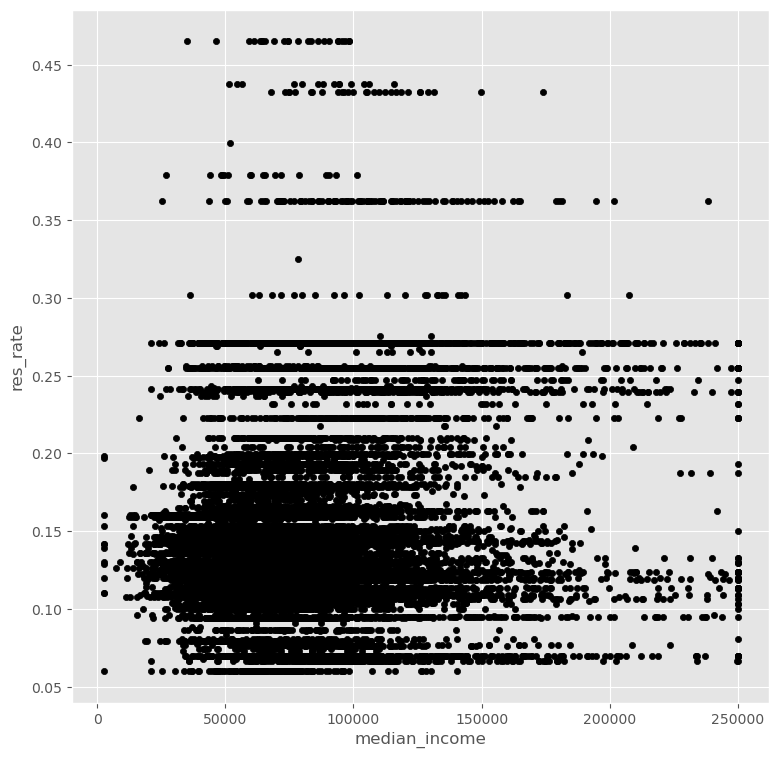

In [74]:
assembled.plot(kind="scatter",
           x="median_income",
           y="res_rate",
           figsize=(9,9),
           color="black");
plt.show()

In [75]:
from sklearn import linear_model

# Initialize model
regression_model = linear_model.LinearRegression()

# Train the model using the assembled data
regression_model.fit(X = pd.DataFrame(assembled["median_income"]), 
                     y = assembled["res_rate"])

# Check trained model y-intercept
print(regression_model.intercept_)

# Check trained model coefficients
print(regression_model.coef_)

0.12353713083092951
[2.76081942e-07]


In [76]:
regression_model.score(X = pd.DataFrame(assembled["median_income"]), 
                       y = assembled["res_rate"])

0.032076043559450484

In [77]:
train_prediction = regression_model.predict(X = pd.DataFrame(assembled["median_income"]))

# Actual - prediction = residuals
residuals = assembled["res_rate"] - train_prediction

residuals.describe()

count    2.409500e+04
mean    -1.680885e-17
std      4.948064e-02
min     -1.260774e-01
25%     -2.892170e-02
50%     -9.570871e-03
75%      1.636489e-02
max      3.320306e-01
Name: res_rate, dtype: float64

In [78]:
SSResiduals = (residuals**2).sum()

SSTotal = ((assembled["res_rate"] - assembled["res_rate"].mean())**2).sum()

# R-squared
1 - (SSResiduals/SSTotal)

0.032076043559450484

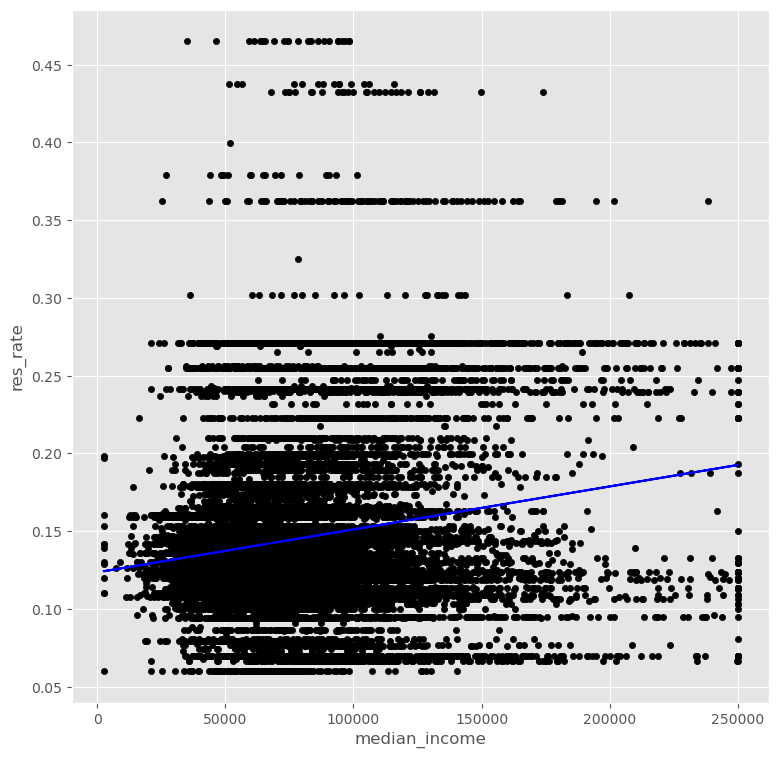

In [79]:
assembled.plot(kind="scatter",
           x="median_income",
           y="res_rate",
           figsize=(9,9),
           color="black",
              )

# Plot regression line
plt.plot(assembled["median_income"],      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue");

plt.show()